In [ ]:
pip install -U git+https://github.com/MIROptics/ECC2025.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.circuit import ParameterVector
from qiskit_algorithms.optimizers import COBYLA
from itertools import product

from ECC2025.testing import test_8a, test_8b

Los algoritmos variacionales cuánticos (VQA) son una clase prometedora de algoritmos híbridos cuántico-clásicos que utilizan un circuito cuántico parametrizado y un optimizador clásico para resolver problemas complejos, como encontrar mínimos energéticos de moléculas o realizar aprendizaje automático. A pesar de su potencial aún existen desafios por superar para escalar estos algoritmos, siendo uno de los más criticos los [__Barren Plateaus (BP)__](https://www.nature.com/articles/s41467-018-07090-4).

El problema de los BP surge cuando el landscape de la función de costo que se optimiza es extremadamente plano en una región amplia del espacio de parámetros. Esto implica que el gradiente de la función de costo es casi __nulo__ en esas regiones, dificultando significativamente la capacidad del optimizador clásico para encontrar direcciones de mejora. En tales casos, el entrenamiento del algoritmo se vuelve ineficiente, ya que requiere un número __exponencial__ de evaluaciones del gradiente para escapar de estas mesetas y aproximarse al óptimo. La presencia de BP está vinculada a varios factores, incluyendo la profundidad del circuito cuántico, la naturaleza del Hamiltoniano, y la inicialización de los parámetros. Entender y mitigar los BP es un área activa de investigación, con enfoques que incluyen diseños de circuitos específicos, estrategias de inicialización y métodos de optimización alternativos. En este desafio veremos como mitigar BP en un autoencoder cuántico.

![](https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/desafios/img/ECC2025_BP_lanscape.png)

Consideremos un autoencoder cuántico, es decir, un sistema bipartico $AB$ compuesto de $n_A$ y $n_B$ qubits, respectivamente, y un circuito variacional cuántico $V(\theta)$ que comprime un estado input $|\psi\rangle$. La función de costo a minimizar es
$$ C_G = 1 - \langle \psi |\left(I_A\otimes|0\cdots0\rangle\langle0\cdots0|_B\right) |\psi \rangle. $$
Esta función de costo puede reescribir como
$$C_G = \langle \psi | H_G | \psi \rangle, $$
donde $H_G$ es el siguiente Hamiltoniano.
$$ H_G = I_{AB} - I_A\otimes|0\cdots0\rangle\langle0\cdots0|_B. $$
Este Hamiltonian sufre de BP ya que es global, es decir, tiene componentes que actúan no trivialmente sobre un grán número de qubits. Especificamente, el término $|0\cdots0\rangle\langle0\cdots0|_B$, el cual actúa sobre $n_B$ qubits. Este problema se puede solucionar cambiando el Hamiltoniano $H_G$ por una versión "local" $H_L$ que actúa sobre pocos qubits, dado por
$$ H_L = I_{AB} - \frac{1}{n_B}\sum_{j=1}^{n_B} I_A\otimes |0\rangle\langle0|_j\otimes I_{\bar{j}},$$
donde $|0\rangle\langle0|_j$ solo actúa sobre el qubit $j$ e $I_{\bar{j}}$ es la identidad en todos los qubits de $B$ excepto en el qubit $j$. Se ha [demostrado](https://www.nature.com/articles/s41467-021-21728-w) que este tipo de Hamiltonianos no exhibe barren plateaus para circuitos parametricos de profundidad baja $\mathcal{O}(\log(n))$. Sea
$$C_L = \langle \psi | H_L | \psi \rangle, $$
la nueva función objetivo con el Hamiltoniano local. Entonces, tenemos que
$$ C_L \leq C_G \leq n_B C_L,$$
es decir, la función local acota por abajo y por arriba la función global, de modo que tienen el mismo optimo y minimizar una tambien minimiza la otra.

__Desafio:__ Considere $n_A=1$ y $n_B=8$. Consideremos que queremos comprimir el siguiente estado mixto
$$ \rho = \frac{2}{3}|\psi_1\rangle\langle\psi_1| +\frac{1}{3}|\psi_2\rangle\langle\psi_2|, $$
donde
$$|\psi_1\rangle=|0\cdots000\rangle_B |0\rangle_A,$$
$$|\psi_2\rangle=|0\cdots011\rangle_B |1\rangle_A.$$
Complete el circuito ``qc_dato`` para que implemente este estado mixto. Para esto es necesario incluir un qubit auxiliar y preparar el estado puro
$$ |\Psi\rangle = \sqrt{\frac{2}{3}}|0\rangle|\psi_1\rangle +  \sqrt{\frac{1}{3}}|1\rangle|\psi_2\rangle  . $$

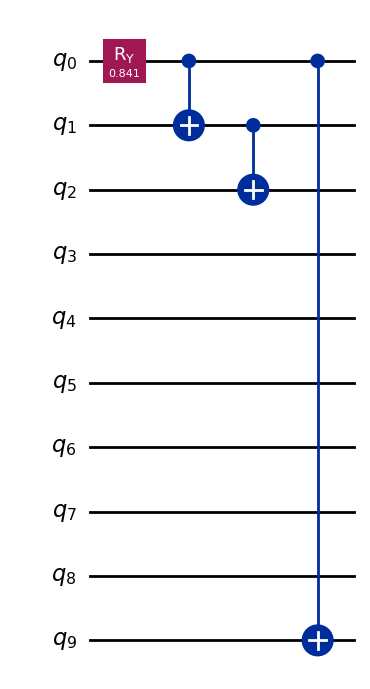

In [3]:
num_qubits_A = 1
num_qubits_B = 8
num_qubits = num_qubits_A + num_qubits_B

qc_dato = QuantumCircuit(num_qubits+1)
### Escriba su solución acá ###########

####################################

qc_dato.draw('mpl') 

In [ ]:
test_8a( qc_dato )

Ahora incluiremos varias capas de puertas cuánticas paramétricas como arquitectura de nuestro autoencoder cuántico,

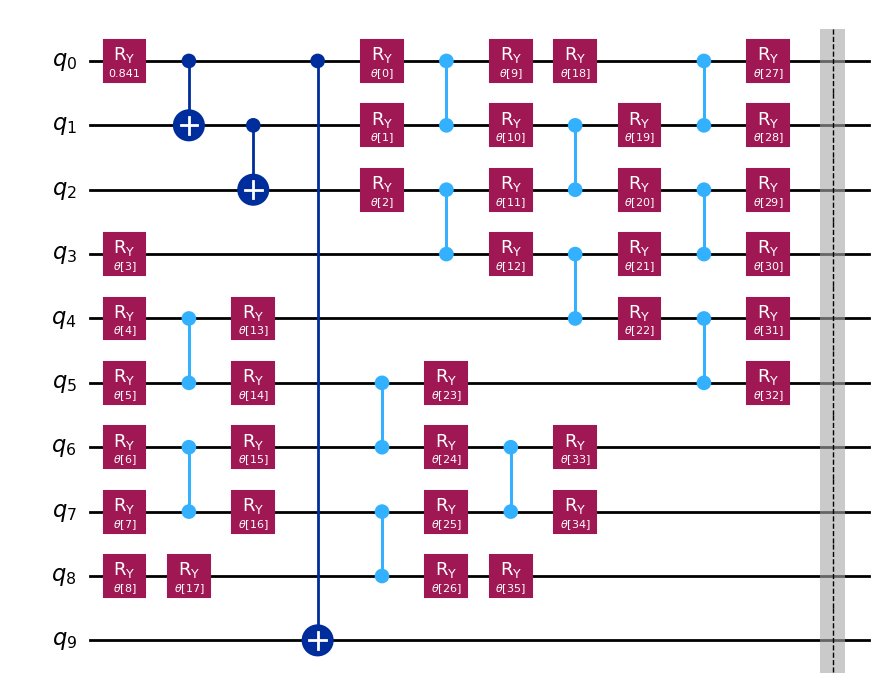

In [5]:
num_layers = int( np.log2(num_qubits) )
theta = ParameterVector(r'$\theta$',(num_layers+1)*num_qubits)

for layer in range(num_layers):
    for j in range(num_qubits):
        qc_dato.ry( theta[num_qubits*layer+j], j )
    if layer%2==0:
        for j in range(0,num_qubits-1,2):
            qc_dato.cz(j,j+1)
    else:
        for j in range(1,num_qubits-1,2):
            qc_dato.cz(j,j+1)
for j in range(num_qubits):
    qc_dato.ry( theta[num_layers*num_qubits+j], j )

qc_dato.barrier()
qc_dato.draw('mpl')

__Desafio:__ Complete las siguientes funciones para que implementen los Hamiltonianos global $H_g$ Y local $H_L$. Para esto recuerde que
$$|0\rangle\langle0|=\frac{1}{2}( I + \sigma_z ), $$
con $\sigma_z$ la matriz de Pauli Z.

In [6]:
def global_hamiltonian():

    H_global = SparsePauliOp( num_qubits*'I', 0 ) #Esto es solo una opción por defecto

    ## Escriba su solución acá ######
 
    ########################################

    return  H_global

def local_hamiltonian():

    H_local = SparsePauliOp( num_qubits*'I', 0 ) #Esto es solo una opción por defecto

    ## Escriba su solución acá ######

    ########################################

    return H_local

In [ ]:
test_8b(global_hamiltonian, local_hamiltonian)

La función de la siguiente celda entrena el autoencoder cuántico con el Hamiltoniano global $H_G$. Podemos ver que el entrenamiento falla y que la función objetivo se mantiene constante, o en otras palabras, tenemos un BP. Esto se debe a que el Hamiltoniano $H_G$ es global y a que estamos usando un número de shots bajo. El BP puede eliminarse aumentando el número de shots hasta un valor suficientemente alto. Sin embargo, en aplicaciones prácticas con número alto de qubit, el número de shots para evitar el BP puede set tan alto que tomaría demasiado tiempo ejecutarlos. En este desafio consideramos un número bajo de shots para inducir el BP en un número bajo de qubits y así evitar tiempos de simulación largos.

In [8]:
shots = 100
np.random.seed(0)
params_init = np.pi*np.random.rand(qc_dato.num_parameters)
shots

100

/tmp/ipykernel_95979/1070632184.py:21: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  fs_global = Global_QAE(params_init)
/tmp/ipykernel_95979/1070632184.py:21: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  fs_global = Global_QAE(params_init)


{   'fun': np.float64(1.0),
    'jac': None,
    'nfev': 217,
    'nit': None,
    'njev': None,
    'x': array([1.72414847, 2.24683366, 1.89363699, 1.711801  , 1.33095081,
       2.0291362 , 1.37472077, 2.80158751, 3.02743585, 1.20461706,
       2.48727756, 1.66157239, 1.78456462, 2.9078476 , 0.22316636,
       0.27372477, 0.06351797, 2.61575239, 2.44465153, 2.73322377,
       3.07442019, 2.51063067, 1.44978017, 2.45210473, 0.37157007,
       2.01037118, 0.45035763, 2.96776493, 1.63943485, 1.3026989 ,
       0.83112597, 2.43232687, 1.43303853, 1.78578792, 0.0590299 ,
       1.94035914])}


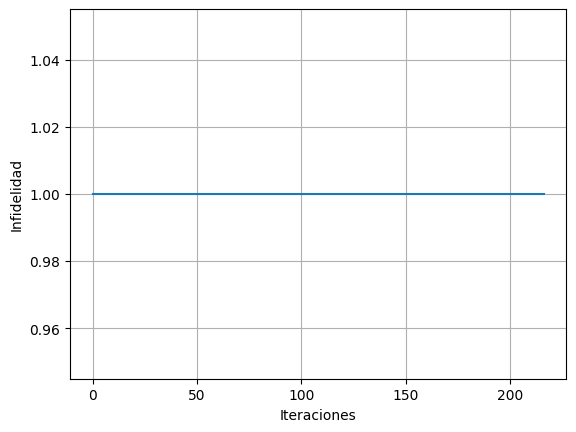

In [9]:
def Global_QAE(x0=np.zeros(qc_dato.num_parameters), rhobeg=1):

    H_global = global_hamiltonian()

    backend = Estimator(run_options={'seed':0})

    def fun_global( params ):
        job   = backend.run( qc_dato, H_global, params, shots=shots )
        probs = job.result().values[0]
        return 1-probs

    fs = []
    def callback(x):
        fs.append(fun_global(x)) 

    optimizer = COBYLA( callback=callback, rhobeg=rhobeg )
    results_global   = optimizer.minimize( fun_global, x0 )
    print( results_global ) 
    return fs

fs_global = Global_QAE(params_init) 

plt.plot( fs_global )
plt.ylabel('Infidelidad')
plt.xlabel('Iteraciones')
plt.grid()
# plt.ylim(10**(-4),1.05)

Ahora entrenemos el autoencoder cuántico con el Hamiltoniano local $H_L$. En la siguiente figura podemos ver que el Hamiltoniano local efectivamente permite entrenar el autoencoder. Además, se observa como la función objetivo global esta acotado tanto por abajo como por arriba por la función objetivo local, y que se minimizan simultaneamente.

/tmp/ipykernel_95979/4019936791.py:27: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  x_local, fs_local = Local_QAE(params_init)
/tmp/ipykernel_95979/4019936791.py:27: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  x_local, fs_local = Local_QAE(params_init)


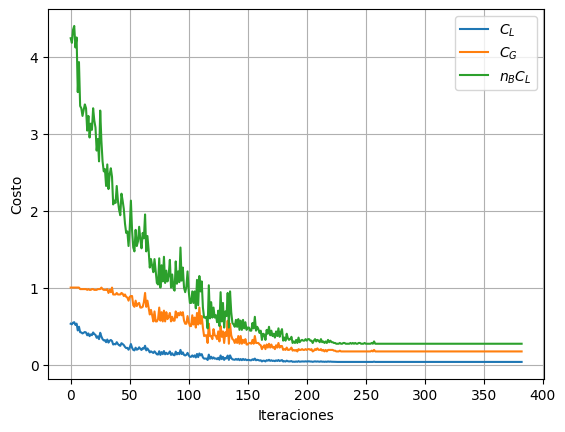

In [10]:
def Local_QAE(x0=np.zeros(qc_dato.num_parameters), rhobeg=1 ):

    H_global = global_hamiltonian()
    H_local = local_hamiltonian()

    backend = Estimator(run_options={'seed':0})

    def fun_global( params ):
        job   = backend.run( qc_dato, H_global, params, shots=shots )
        probs = job.result().values[0]
        return 1-probs

    def fun_local( params ):
        job   = backend.run( qc_dato, H_local, params, shots=shots )
        probs = job.result().values[0]
        return 1-probs

    fs = []
    def callback(x):
        fs.append( [fun_local(x), fun_global(x), num_qubits_B*fun_local(x)] )

    optimizer = COBYLA( callback=callback, rhobeg=rhobeg )
    results_local   = optimizer.minimize( fun_local, x0 )

    return results_local.x, fs

x_local, fs_local = Local_QAE(params_init)
plt.plot( fs_local )
plt.grid()
plt.ylabel('Costo')
plt.xlabel('Iteraciones')
# plt.ylim(-0.05,1.05)
plt.legend([r'$C_L$', r'$C_G$', r'$n_BC_L$'])

En la figura anterior podemos ver que con el Hamiltoniano local permite entrenar el circuito. Además, se observa como la función objetivo global esta acotado tanto por abajo como por arriba por la función objetivo local, y que se minimizan simultaneamente.